In [1]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from copy import deepcopy
from tqdm import tqdm
from game import *

pygame 2.1.2 (SDL 2.0.18, Python 3.10.6)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# for reproducibility
my_seed = 0
np.random.seed(my_seed)
torch.manual_seed(my_seed)

# Creating The Q-Table
action_space_size = 4  # Up-left-down-right
state_space_size = 5*5*5*5 # All possible permutations of bitstring og length 12
print("action_space_size: ", action_space_size)
print("state_space_size: ", state_space_size)
q_table = create_q_table_dict()

# View good score games while training ?
view_games = True

# Stats for plotting
loss_means = []
highest_scores = []
best_play_models = []

# Initializing Q-Learning Parameters
num_episodes = 500000 # try 100000
max_steps_per_episode = 100000

learning_rate = 0.000025 # try 0.0005
discount_rate = 0.95 # try 0.95

max_exploration_rate = 1
min_exploration_rate = 0.000075 # try 0.001
exploration_decay_rate = 0.000025 # try 0.0005
exploration_rate = max_exploration_rate  # Initially exploring (all q-table vals = 0 at beginning)


# The Q-Learning Algorithm Training Loop
rewards_all_episodes = []
exploration_rates = []
action_map = {"up": 0, "down": 1, "left": 2, "right": 3}

high_score = 0
high_score_seed = 0
high_score_episode = 0
rate_flag = True

for episode in tqdm(range(num_episodes)):
    agent = SimpleSnakeApp(seed=my_seed + episode,  # Try both constant seed and varying seed for each episode
                           Q_table=q_table,
                           display_gameplay=False)

    done = False
    rewards_current_episode = 0
    my_random_flag = False

    q_table_copy = q_table
    for step in range(max_steps_per_episode):

        # Exploration-exploitation trade-off
        exploration_rate_threshold = np.random.uniform(0, 1)
        if exploration_rate_threshold > exploration_rate:
            # Use Q table
            my_random_flag = False
        else:
            # Random action
            my_random_flag = True
        # Take new action
        reward, running, action, _state, new_state = agent.step(my_random_flag)
        _state = tensor_2_string(_state)
        new_state = tensor_2_string(new_state)
        action = action_map[action]
        done = not running

        # Update Q-table (using Bellman equation for Optimal Q-value function)
        q_table[_state][action] = q_table[_state][action] * (1 - learning_rate) + learning_rate * (
                    reward + discount_rate * np.max(q_table[new_state]))

        # Add new reward
        rewards_current_episode += reward

        if done:
            break

    # Exploration rate decay
    exploration_rate = min_exploration_rate + (max_exploration_rate - min_exploration_rate) * np.exp(
        -exploration_decay_rate * episode)


    # Add current episode reward to total rewards list
    rewards_all_episodes.append(rewards_current_episode)

    if rewards_current_episode > high_score:
        high_score = rewards_current_episode
        high_score_seed = my_seed+episode
        high_score_episode = episode
        saveQtable(filename="bestqtable.txt",qtable_dict=q_table_copy)

action_space_size:  4
state_space_size:  625


 75%|███████▌  | 375234/500000 [50:58<16:56, 122.70it/s] 


KeyboardInterrupt: 

In [3]:
print("High score:", high_score, " at episode: ", high_score_episode)

High score: 51  at episode:  339204


/Users/sebastianyde/miniforge3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/sebastianyde/miniforge3/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


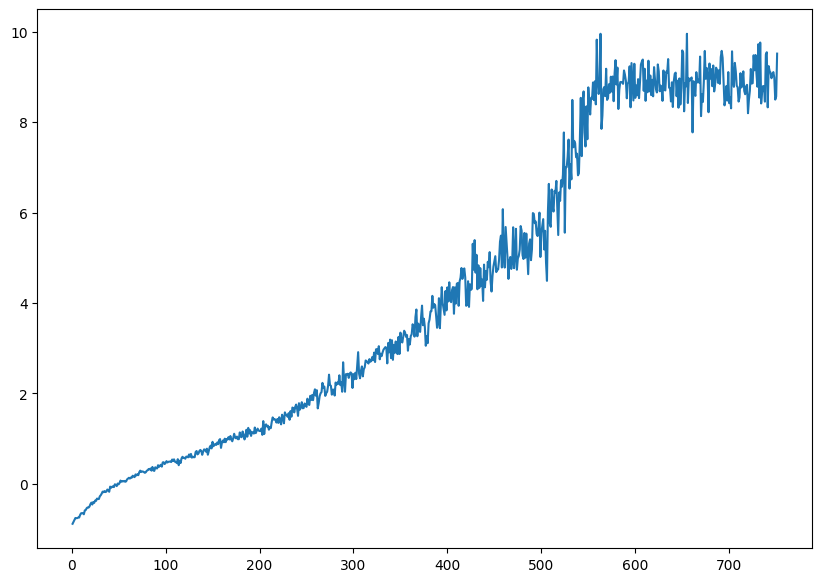

In [4]:
# Calculating average over 100's of episodes
batch_size = 500
avg_rewards = []
for batch in range(int(num_episodes/batch_size)):
    avg_rewards.append(np.mean(rewards_all_episodes[batch_size * batch : batch_size * (batch + 1)]))

# Plot reward of each 'episode'
fig, ax = plt.subplots(1,1,figsize=(10,7))
ax.plot(list(range(1, len(avg_rewards)+1)), avg_rewards)
plt.show()

In [8]:
#high_score_qtable = loadQtable(filename="bestqtable.txt")
Game = SimpleSnakeApp(seed=12465,
                      Q_table=q_table,
                      display_gameplay=True)
Game.on_execute()
print("Game loss:", Game.loss)
print("Game reward:", Game.current_reward)
pygame.display.quit()
pygame.quit()

KeyboardInterrupt: 